# Artificial neural networks (ANNs) for image data
_by Phil Harrison (February 2021)_
#### Dataset
For this exercise we will use the MNIST dataset: greyscale images (28 x 28 pixels) of hand-written digits that we wish to classify into their corresponding ten categories (0 to 9). Note we now have a classification problem, as opposed to the QSAR regression problem from part 1 of today's lab. The MNIST dataset is a classical benchmark dataset in machine learning, a first port of call for testing new neural network architectures. It consists of 60,000 training images and 10,000 test images. It is like the 'Hello world' for neural networks. The images were collected by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. The images were centred and scaled to fit into the 28 x 28 pixel crops.

<p>
    <img src="figs/mnist.png" alt="drawing" style="width:800px;"/>
    <center>Figure 1. Example MNIST images (figure from Wikipedia).</center>
</p>

#### Modelling approach
Here we will flatten the 28 x 28 pixel images into vectors of size 785 (= 28*28) and try to solve the classification problem with ANNs. For such a simple task with such small size images this will work quite well. As we move to larger images, with more image channels (such as red, green and blue (RGB) as in most colour images), such flattening and analysis with plain (vanilla) neural networks will not work. How to more adequately deal with more complex image data and classification problems will be the focus of the lectures and labs during the rest of this week. One point to note with respect to this flattening of the data is that we lose spatial information (think about it, each pixel in an image tends to be correlated with the pixels to the left, right, above and below it). How might we accomodate for this? Well, an extremely good approach is to use convolutional neural networks (CNNs, the focus of the lecture and lab tomorrow and the assignment you will do). For this lab we will overlook this complication and move forward with a flattened representation of the image data.

#### References
This section of the lab borrows/steals heavily from material from the book written by Francois Chollet (the invenor of Keras!; https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). This book is great! I highly recommed it. Some ideas I also stole from the Udemy course (https://www.udemy.com/course/deep-learning-tensorflow-2/), which was also quite good... Whilst I'm at it, for those who are interested, I highly recommend checking out Coursera (https://www.coursera.org/) and Udemy (https://www.udemy.com/), two online platforms where you can learn much more about AI, machine learning and deep learning. 

## Load packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, datasets
from tensorflow.keras.utils import to_categorical

# Helper libraries
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print(tf.__version__)

2.1.0


## Plotting functions

In [2]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')

    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    plt.show()
    plt.close()

def plot_confusion_matrix(cm, classes, model_name,
                          cmap=plt.cm.Blues):
    title = model_name + ': Confusion Matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Load and preprocess data
We will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the `[0, 1]` interval. Our training images were downloaded in an array of shape `(60000, 28, 28)` of type `uint8` with values in the `[0, 255]` interval. We will transform this into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

As we will compare multiple models below it makes sense to split the training dataset up into a 'proper' training set and a validation set. The validations set we will use to decide on the best model. For a final evaluation we then use the test set, which we do not look at until the end.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
class_names = list(np.arange(10))

n_train0 = 60000
X = train_images.reshape((n_train0, 28 * 28))
X = X.astype('float32') / 255

random.seed(4826)
indices = np.arange(n_train0)
random.shuffle(indices)

n_train = int(n_train0 * 0.8) # 80% of data for (proper) training and 20% for validation
X_train, X_valid = X[indices[:n_train]], X[indices[n_train:]]

X_test = test_images.reshape((10000, 28 * 28))
X_test = X_test.astype('float32') / 255

y_train = to_categorical(train_labels[indices[:n_train]])
y_valid = to_categorical(train_labels[indices[n_train:]])
y_test = to_categorical(test_labels)

## First pass model
A quote from Francois Chollet to get us started:

"The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a succession of increasingly refined data filters -- the "layers"."

Note below we have a mutliclasss classifcation problem so we need to use a softmax activation for the final predictions.

## Define and summarise model

In [4]:
inps = layers.Input(shape=X_train[0].shape)
x = layers.Dense(32, activation='relu')(inps)
preds = layers.Dense(10, activation='softmax')(x)

ANN1 = models.Model(inputs=inps, outputs=preds)
ANN1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


As we have a classification problem we need to use a different loss function than the MSE we used for regression. In this case we shall use categorical crossentropy. For classification tasks we can also monitor the accuracy of our predictions as the model trains across the epochs. The loss and metrics to keep track of are specified when we compile the model.

## Complile, fit and evaluate model

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 - 6s - loss: 0.3779 - accuracy: 0.8950 - val_loss: 0.2411 - val_accuracy: 0.9318
Epoch 2/10
48000/48000 - 5s - loss: 0.2134 - accuracy: 0.9395 - val_loss: 0.1992 - val_accuracy: 0.9438
Epoch 3/10
48000/48000 - 5s - loss: 0.1692 - accuracy: 0.9517 - val_loss: 0.1693 - val_accuracy: 0.9518
Epoch 4/10
48000/48000 - 5s - loss: 0.1423 - accuracy: 0.9595 - val_loss: 0.1541 - val_accuracy: 0.9576
Epoch 5/10
48000/48000 - 5s - loss: 0.1250 - accuracy: 0.9646 - val_loss: 0.1489 - val_accuracy: 0.9595
Epoch 6/10
48000/48000 - 5s - loss: 0.1128 - accuracy: 0.9684 - val_loss: 0.1418 - val_accuracy: 0.9607
Epoch 7/10
48000/48000 - 5s - loss: 0.1042 - accuracy: 0.9699 - val_loss: 0.1492 - val_accuracy: 0.9609
Epoch 8/10
48000/48000 - 5s - loss: 0.0978 - accuracy: 0.9722 - val_loss: 0.1432 - val_accuracy: 0.9619
Epoch 9/10
48000/48000 - 5s - loss: 0.0904 - accuracy: 0.9745 - val_loss: 0.1448 - val_accuracy: 0.9613
Epoch 10/10
48

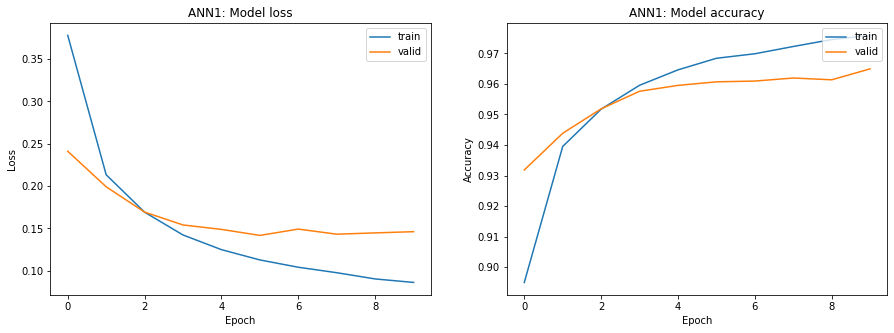

ANN1 on validation data: loss = 0.146; acc = 0.965


In [5]:
lr = 0.001
n_epochs = 10

ANN1.compile(optimizer=optimizers.RMSprop(lr=lr), 
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = ANN1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=n_epochs, verbose=2)
plot_history(history, 'ANN1')

val_loss, val_acc = ANN1.evaluate(X_valid, y_valid, verbose=0)
print('ANN1 on validation data: loss = ' + str(np.round(val_loss, 3)) + 
      '; acc = ' + str(np.round(val_acc, 3)))

## Explore alternative models
Below you should define, compile and fit (at least two) more models and evaluate them on the validation data. You can explore making the model wider (with more neurons per layer) and deeper (with more layers). You could also explore adding dropout. It is often difficult in advance to say how wide and deep neural network architectures should be for a given dataset and hence some exploration, some trial and error, is often required. You can also change the number of epochs to train for if it looks like your validation loss still wants to go down.

In [6]:
inps = layers.Input(shape=X_train[0].shape)
x = layers.Dense(64, activation='relu')(inps)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(10, activation='softmax')(x)

ANN2 = models.Model(inputs=inps, outputs=preds)
ANN2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 - 6s - loss: 0.4043 - accuracy: 0.8825 - val_loss: 0.1838 - val_accuracy: 0.9452
Epoch 2/10
48000/48000 - 6s - loss: 0.1913 - accuracy: 0.9462 - val_loss: 0.1422 - val_accuracy: 0.9568
Epoch 3/10
48000/48000 - 6s - loss: 0.1494 - accuracy: 0.9580 - val_loss: 0.1315 - val_accuracy: 0.9629
Epoch 4/10
48000/48000 - 6s - loss: 0.1291 - accuracy: 0.9637 - val_loss: 0.1347 - val_accuracy: 0.9631
Epoch 5/10
48000/48000 - 6s - loss: 0.1173 - accuracy: 0.9684 - val_loss: 0.1326 - val_accuracy: 0.9648
Epoch 6/10
48000/48000 - 6s - loss: 0.1087 - accuracy: 0.9699 - val_loss: 0.1242 - val_accuracy: 0.9680
Epoch 7/10
48000/48000 - 6s - loss: 0.1029 - accuracy: 0.9733 - val_loss: 0.1326 - val_accuracy: 0.9669
Epoch 8/10
48000/48000 - 6s - loss: 0.1014 - accuracy: 0.9737 - val_loss: 0.1539 - val_accuracy: 0.9682
Epoch 9/10
48000/48000 - 6s - loss: 0.0962 - accuracy: 0.9751 - val_loss: 0.1494 - val_accuracy: 0.9657
Epoch 10/10
48

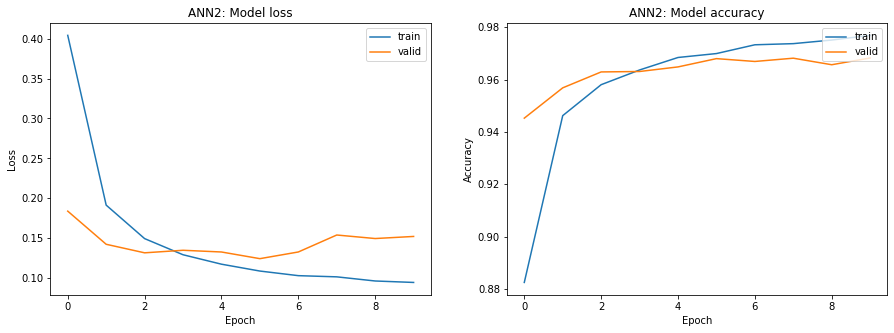

ANN2 on validation data: loss = 0.152; acc = 0.968


In [7]:
lr = 0.001
n_epochs = 10

ANN2.compile(optimizer=optimizers.RMSprop(lr=lr), 
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = ANN2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=n_epochs, verbose=2)
plot_history(history, 'ANN2')

val_loss, val_acc = ANN2.evaluate(X_valid, y_valid, verbose=0)
print('ANN2 on validation data: loss = ' + str(np.round(val_loss, 3)) +
     '; acc = ' + str(np.round(val_acc, 3)))

In [8]:
inps = layers.Input(shape=X_train[0].shape)
x = layers.Dense(256, activation='relu')(inps)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(10, activation='softmax')(x)

ANN3 = models.Model(inputs=inps, outputs=preds)
ANN3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 - 6s - loss: 0.2742 - accuracy: 0.9205 - val_loss: 0.1494 - val_accuracy: 0.9547
Epoch 2/10
48000/48000 - 5s - loss: 0.1362 - accuracy: 0.9602 - val_loss: 0.1178 - val_accuracy: 0.9666
Epoch 3/10
48000/48000 - 5s - loss: 0.1051 - accuracy: 0.9706 - val_loss: 0.1215 - val_accuracy: 0.9659
Epoch 4/10
48000/48000 - 5s - loss: 0.0876 - accuracy: 0.9753 - val_loss: 0.1083 - val_accuracy: 0.9723
Epoch 5/10
48000/48000 - 5s - loss: 0.0755 - accuracy: 0.9794 - val_loss: 0.1048 - val_accuracy: 0.9743
Epoch 6/10
48000/48000 - 5s - loss: 0.0678 - accuracy: 0.9816 - val_loss: 0.1067 - val_accuracy: 0.9747
Epoch 7/10
48000/48000 - 5s - loss: 0.0615 - accuracy: 0.9832 - val_loss: 0.1016 - val_accuracy: 0.9762
Epoch 8/10
48000/48000 - 5s - loss: 0.0579 - accuracy: 0.9845 - val_loss: 0.1087 - val_accuracy: 0.9764
Epoch 9/10
48000/48000 - 5s - loss: 0.0529 - accuracy: 0.9865 - val_loss: 0.1015 - val_accuracy: 0.9778
Epoch 10/10
48

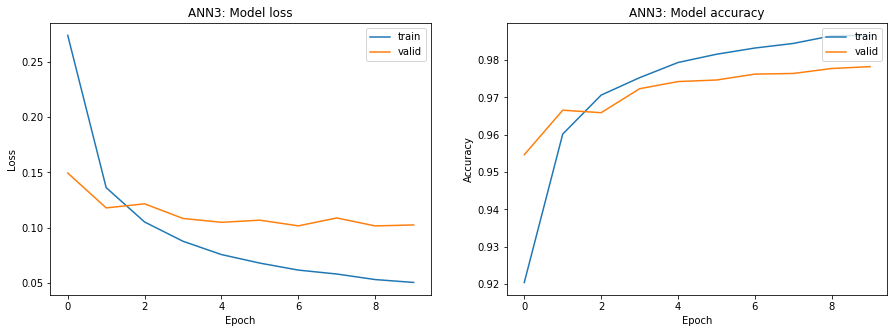

ANN3 on validation data: loss = 0.102; acc = 0.978


In [9]:
lr = 0.001
n_epochs = 10

ANN3.compile(optimizer=optimizers.RMSprop(lr=lr), 
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = ANN3.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=n_epochs, verbose=2)
plot_history(history, 'ANN3')

val_loss, val_acc = ANN3.evaluate(X_valid, y_valid, verbose=0)
print('ANN3 on validation data: loss = ' + str(np.round(val_loss, 3)) +
     '; acc = ' + str(np.round(val_acc, 3)))

## Final evaluation on test data
My best model on the validation data was the third one I tried (ANN3). In the code cell below change all the 'ANN3's to the name you gave your best model above and run the cell to see your final test loss, accuracy and a confusion matrix for the results.

ANN3 on test data: loss = 0.095; acc = 0.977


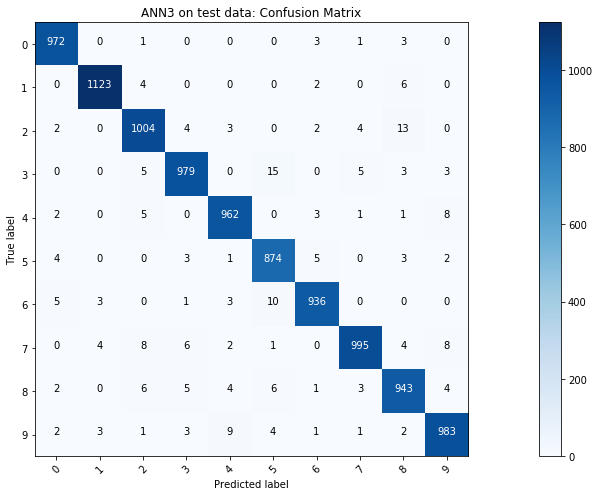

In [10]:
test_loss, test_acc = ANN3.evaluate(X_test, y_test, verbose=0)
print('ANN3 on test data: loss = ' + str(np.round(test_loss, 3)) +
     '; acc = ' + str(np.round(test_acc, 3)))

y_pred = ANN3.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

cnf_matrix = confusion_matrix(y_test.argmax(axis=-1), y_pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(20,7), facecolor='w')
plot_confusion_matrix(cnf_matrix, classes=class_names, model_name='ANN3 on test data')

plt.show()
plt.close()

Look to the confusion matrix above. Are the highest numbers for those misclassified for the test data (i.e. those on the off-diagonals) the numbers you might expected would be easier to mix up when based on different people's hand-writing? 

Running the code cell below will plot a randomly chosen set of four examples where the predictions were wrong. You can run it multiple times to see different examples. Some of the mistakes are obvious, others are less so. Those that are less so could be due, for example, to a somewhat off average slant in how the digits were written. Afterall, flattening the images as we did looks at each pixel in isolation. If we can take the correlated nature of image pixels into account we can do much better. The best way of doing this is to use convolutional neural networks (CNNs), the focus of the rest of this week. With CNNs on the MNIST data we can easily get greater than 99% accuracy on the MNIST test images!

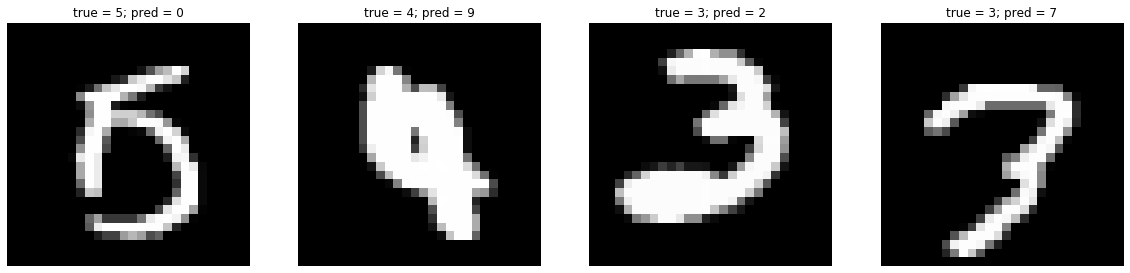

In [16]:
y_test_vec = y_test.argmax(axis=-1)
mis_indices = np.where(y_test_vec != y_pred)[0]
mis_samp = np.random.choice(mis_indices, 4)
fig = plt.figure(figsize=(20, 10), facecolor='w')
for i in range(4):
    sub_index = 241 + i
    plt.subplot(sub_index)
    plt.imshow(test_images[mis_samp[i]], cmap='gray')
    plt.axis('off')
    plt.title('true = ' + str(y_test_vec[mis_samp[i]]) + 
             '; pred = ' + str(y_pred[mis_samp[i]]))

plt.show()
plt.close()